In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import datetime as dt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


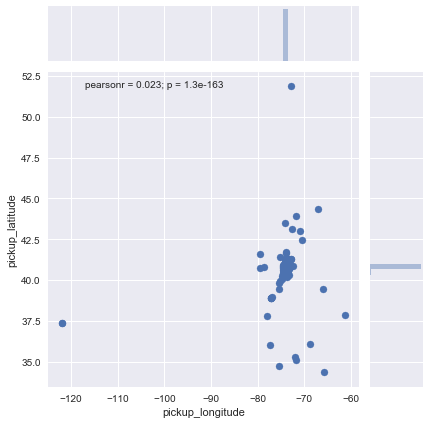

In [4]:
sns.jointplot(x="pickup_longitude", y="pickup_latitude", data=train);

In [5]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [6]:
test.shape

(625134, 9)

In [7]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[(train['trip_duration'] <= m + 2*s) & (train['trip_duration'] >= m -2*s)]
train = train[(train['pickup_longitude'] > -74.023822) & (train['pickup_latitude'] < 40.886345) & (train['pickup_longitude'] < -73.901599) & (train['pickup_latitude'] > 40.698160)]

In [8]:
test_id = test['id']

In [9]:
train['source'] = 'train'
test['source'] = 'test'
df = pd.concat([train, test], ignore_index=True)

In [10]:
#sns.jointplot(x = 'pickup_longitude', y = 'pickup_latitude', data = df, s = 4)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990557 entries, 0 to 1990556
Data columns (total 12 columns):
dropoff_datetime      object
dropoff_latitude      float64
dropoff_longitude     float64
id                    object
passenger_count       int64
pickup_datetime       object
pickup_latitude       float64
pickup_longitude      float64
source                object
store_and_fwd_flag    object
trip_duration         float64
vendor_id             int64
dtypes: float64(5), int64(2), object(5)
memory usage: 182.2+ MB


In [12]:
df.describe()

,dropoff_latitude,dropoff_longitude,passenger_count,pickup_latitude,pickup_longitude,trip_duration,vendor_id
count,1.990557e+06,1.990557e+06,1.990557e+06,1.990557e+06,1.990557e+06,1.365423e+06,1.990557e+06
mean,4.075267e+01,-7.397441e+01,1.661832e+00,4.075285e+01,-7.397868e+01,7.723499e+02,1.533578e+00
std,3.258285e-02,4.933976e-02,1.312092e+00,2.481170e-02,4.366096e-02,5.596175e+02,4.988713e-01
min,3.639812e+01,-1.219333e+02,0.000000e+00,3.738959e+01,-1.219331e+02,1.000000e+00,1.000000e+00
25%,4.073701e+01,-7.399142e+01,1.000000e+00,4.073860e+01,-7.399226e+01,3.860000e+02,1.000000e+00
50%,4.075495e+01,-7.397997e+01,1.000000e+00,4.075438e+01,-7.398222e+01,6.350000e+02,2.000000e+00
75%,4.077022e+01,-7.396364e+01,2.000000e+00,4.076783e+01,-7.396950e+01,1.004000e+03,2.000000e+00
max,4.885760e+01,-6.749680e+01,9.000000e+00,4.281494e+01,-6.924892e+01,1.141100e+04,2.000000e+00


In [13]:
df.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,source,store_and_fwd_flag,trip_duration,vendor_id
0,2016-03-14 17:32:30,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,train,N,455.0,2
1,2016-06-12 00:54:38,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,train,N,663.0,1
2,2016-01-19 12:10:48,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,train,N,2124.0,2
3,2016-04-06 19:39:40,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,train,N,429.0,2
4,2016-03-26 13:38:10,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,train,N,435.0,2


In [14]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_hour'] = df['pickup_datetime'].dt.hour

In [15]:
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [16]:
df['dropoff_month'] = df['dropoff_datetime'].dt.month
df['dropoff_day_of_week'] = df['dropoff_datetime'].dt.dayofweek
df['dropoff_day'] = df['dropoff_datetime'].dt.day
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour

In [17]:
df.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,source,store_and_fwd_flag,trip_duration,vendor_id,pickup_month,pickup_day_of_week,pickup_day,pickup_hour,dropoff_month,dropoff_day_of_week,dropoff_day,dropoff_hour
0,2016-03-14 17:32:30,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,train,N,455.0,2,3,0,14,17,3.0,0.0,14.0,17.0
1,2016-06-12 00:54:38,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,train,N,663.0,1,6,6,12,0,6.0,6.0,12.0,0.0
2,2016-01-19 12:10:48,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,train,N,2124.0,2,1,1,19,11,1.0,1.0,19.0,12.0
3,2016-04-06 19:39:40,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,train,N,429.0,2,4,2,6,19,4.0,2.0,6.0,19.0
4,2016-03-26 13:38:10,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,train,N,435.0,2,3,5,26,13,3.0,5.0,26.0,13.0


In [18]:
coords = np.vstack((df[['pickup_latitude', 'pickup_longitude']],
                    df[['dropoff_latitude', 'dropoff_longitude']]))
sample_ind = np.random.permutation(len(coords))[:1000000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=20000).fit(coords[sample_ind])

In [19]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_latitude', 'dropoff_longitude']])

In [20]:
df.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,source,store_and_fwd_flag,...,pickup_month,pickup_day_of_week,pickup_day,pickup_hour,dropoff_month,dropoff_day_of_week,dropoff_day,dropoff_hour,pickup_cluster,dropoff_cluster
0,2016-03-14 17:32:30,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,train,N,...,3,0,14,17,3.0,0.0,14.0,17.0,27,73
1,2016-06-12 00:54:38,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,train,N,...,6,6,12,0,6.0,6.0,12.0,0.0,34,54
2,2016-01-19 12:10:48,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,train,N,...,1,1,19,11,1.0,1.0,19.0,12.0,85,86
3,2016-04-06 19:39:40,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,train,N,...,4,2,6,19,4.0,2.0,6.0,19.0,29,6
4,2016-03-26 13:38:10,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,train,N,...,3,5,26,13,3.0,5.0,26.0,13.0,76,3


In [21]:
#df['pickup_longitude'].nunique()

In [22]:
df.shape

(1990557, 22)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990557 entries, 0 to 1990556
Data columns (total 22 columns):
dropoff_datetime       datetime64[ns]
dropoff_latitude       float64
dropoff_longitude      float64
id                     object
passenger_count        int64
pickup_datetime        datetime64[ns]
pickup_latitude        float64
pickup_longitude       float64
source                 object
store_and_fwd_flag     object
trip_duration          float64
vendor_id              int64
pickup_month           int64
pickup_day_of_week     int64
pickup_day             int64
pickup_hour            int64
dropoff_month          float64
dropoff_day_of_week    float64
dropoff_day            float64
dropoff_hour           float64
pickup_cluster         int32
dropoff_cluster        int32
dtypes: datetime64[ns](2), float64(9), int32(2), int64(6), object(3)
memory usage: 318.9+ MB


In [24]:
df = df.drop(['store_and_fwd_flag'], axis = 1)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990557 entries, 0 to 1990556
Data columns (total 21 columns):
dropoff_datetime       datetime64[ns]
dropoff_latitude       float64
dropoff_longitude      float64
id                     object
passenger_count        int64
pickup_datetime        datetime64[ns]
pickup_latitude        float64
pickup_longitude       float64
source                 object
trip_duration          float64
vendor_id              int64
pickup_month           int64
pickup_day_of_week     int64
pickup_day             int64
pickup_hour            int64
dropoff_month          float64
dropoff_day_of_week    float64
dropoff_day            float64
dropoff_hour           float64
pickup_cluster         int32
dropoff_cluster        int32
dtypes: datetime64[ns](2), float64(9), int32(2), int64(6), object(2)
memory usage: 303.7+ MB


In [26]:
#calculate the distance between two coordinates
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [27]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [28]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_np(lat1, lng1, lat1, lng2)
    b = haversine_np(lat1, lng1, lat2, lng1)
    return a + b

In [29]:
df['distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

In [30]:
df['manhattan_distance'] = dummy_manhattan_distance(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

# Add new features including SPEED

In [31]:
#groupby pickup hour and piup cluster and dropoff cluster, then calculate the average speed
# df['speed'] = df['manhattan_distance'] / df['trip_duration']
# cluster_speed = df.groupby(['pickup_day_of_week', 'pickup_hour', 'pickup_cluster', 'dropoff_cluster']).mean()

In [32]:
# cluster_speed = cluster_speed.drop(['dropoff_latitude', 'dropoff_longitude', 'passenger_count',
#        'pickup_latitude', 'pickup_longitude', 'trip_duration', 'vendor_id',
#        'pickup_month', 'pickup_day', 'dropoff_month', 'dropoff_day_of_week',
#        'dropoff_day', 'dropoff_hour', 'distance', 'manhattan_distance'], axis = 1)

In [33]:
#cluster_speed = cluster_speed.reset_index(level=['pickup_day_of_week', 'pickup_hour', 'pickup_cluster', 'dropoff_cluster'])

In [34]:
#cluster_speed.columns

In [35]:
#cluster_speed = cluster_speed[['pickup_day_of_week', 'pickup_hour', 'pickup_cluster', 'dropoff_cluster', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude','speed']]

In [36]:
#df002 = pd.merge(df, cluster_speed, how='outer', on=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

In [37]:
#df002.head()

# Deal with categorical values

In [38]:
#use different dataframe to store numerical values
pickup_month = pd.get_dummies(df['pickup_month'], prefix='pickup_month')
pickup_hour = pd.get_dummies(df['pickup_hour'], prefix='pickup_hour')
pickup_dayofweek = pd.get_dummies(df['pickup_day_of_week'], prefix='pickup_day_of_week')
pickup_day = pd.get_dummies(df['pickup_day'], prefix='pickup_day')
dropoff_month = pd.get_dummies(df['dropoff_month'], prefix='dropoff_month')
dropoff_hour = pd.get_dummies(df['dropoff_hour'], prefix='dropoff_hour')
dropoff_dayofweek = pd.get_dummies(df['dropoff_day_of_week'], prefix='dropoff_day_of_week')
dropoff_day = pd.get_dummies(df['dropoff_day'], prefix='dropoff_day')

In [39]:
pickup_cluster = pd.get_dummies(df['pickup_cluster'], prefix='pickup_cluster')
dropoff_cluster = pd.get_dummies(df['dropoff_cluster'], prefix='dropoff_cluster')

In [40]:
passenger_count = pd.get_dummies(df['passenger_count'], prefix='passenger_count')
vendor_id = pd.get_dummies(df['vendor_id'], prefix='vendor_id')

In [41]:
#drop old categorical columns and concat new numerical columns
df_numerical = df.drop(['pickup_cluster', 'pickup_day', 'pickup_day_of_week', 'pickup_hour', 'pickup_month', 'dropoff_cluster', 'dropoff_day', 'dropoff_day_of_week', 'dropoff_hour', 'dropoff_month', 'passenger_count', 'vendor_id'], axis = 1)
df_numerical = pd.concat([df_numerical, pickup_month, pickup_day, pickup_dayofweek, pickup_hour, pickup_cluster, dropoff_month, dropoff_day, dropoff_dayofweek, dropoff_hour, dropoff_cluster, passenger_count, vendor_id], axis = 1)

In [42]:
df_numerical = df_numerical.drop(['pickup_datetime', 'dropoff_datetime'], axis = 1)
df_numerical.head()

,dropoff_latitude,dropoff_longitude,id,pickup_latitude,pickup_longitude,source,trip_duration,distance,manhattan_distance,pickup_month_1,...,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_8,passenger_count_9,vendor_id_1,vendor_id_2
0,40.765602,-73.964630,id2875421,40.767937,-73.982155,train,455.0,1.497580,1.734344,0,...,1,0,0,0,0,0,0,0,0,1
1,40.731152,-73.999481,id2377394,40.738564,-73.980415,train,663.0,1.804374,2.428980,0,...,1,0,0,0,0,0,0,0,1,0
2,40.710087,-74.005333,id3858529,40.763939,-73.979027,train,2124.0,6.381090,8.198424,1,...,1,0,0,0,0,0,0,0,0,1
3,40.706718,-74.012268,id3504673,40.719971,-74.010040,train,429.0,1.484566,1.660288,0,...,1,0,0,0,0,0,0,0,0,1
4,40.782520,-73.972923,id2181028,40.793209,-73.973053,train,435.0,1.187842,1.198704,0,...,1,0,0,0,0,0,0,0,0,1


# Feature Scaling

In [43]:
sc = StandardScaler()

In [44]:
df_numerical['sc_distance'] = sc.fit_transform(df_numerical['distance'])

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [45]:
# df['sc_distance']

In [46]:
df_numerical['direction'] = bearing_array(df_numerical['pickup_latitude'], df_numerical['pickup_longitude'], df_numerical['dropoff_latitude'], df_numerical['dropoff_longitude'])

In [47]:
df_numerical['sc_direction'] = sc.fit_transform(df_numerical['direction'])

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [48]:
df_numerical['sc_pickup_latitude'] = sc.fit_transform(df_numerical['pickup_latitude'])
df_numerical['sc_pickup_longitude'] = sc.fit_transform(df_numerical['pickup_longitude'])

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.resha

# Add OSRM dataset

In [49]:
train_osrm1 = pd.read_csv("new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv")
train_osrm2 = pd.read_csv("new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv")
test_osrm = pd.read_csv("new-york-city-taxi-with-osrm/fastest_routes_test.csv")

In [50]:
train_osrm = pd.concat([train_osrm1, train_osrm2])

In [51]:
train_osrm.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


In [52]:
df_osrm = pd.concat([train_osrm, test_osrm])

In [53]:
df_numerical = df_numerical.merge(df_osrm, how='left', on='id')

In [54]:
df_numerical['number_of_steps'].isnull().sum()

0

In [55]:
df_numerical['sc_dropoff_latitude'] = sc.fit_transform(df_numerical['dropoff_latitude'])
df_numerical['sc_dropoff_longitude'] = sc.fit_transform(df_numerical['dropoff_longitude'])

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.resha

# Feature Scaling for OSRM features

In [56]:
df_numerical['total_distance'] = sc.fit_transform(df_numerical['total_distance'])
df_numerical['total_travel_time'] = sc.fit_transform(df_numerical['total_travel_time'])
df_numerical['number_of_steps'] = sc.fit_transform(df_numerical['number_of_steps'])

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.resha

# Seperate the dataframe back to training set and test set

In [57]:
train_numerical = df_numerical[df_numerical['source'] == 'train']
test_numerical = df_numerical[df_numerical['source'] == 'test']

In [58]:
# train_numerical.to_csv('train_numerical001.csv', index=False)
# test_numerical.to_csv('test_numerical001.csv', index=False)

In [59]:
# list(test_numerical.columns)

In [75]:
X_train = train_numerical.drop(['trip_duration', 'source', 'id', 'starting_street', 'end_street', 'street_for_each_step', 'distance_per_step', 'travel_time_per_step', 'step_maneuvers', 'step_direction', 'step_location_list'], axis = 1)
y_train = train_numerical['trip_duration']

In [76]:
X_test = test_numerical.drop(['trip_duration', 'source', 'id', 'starting_street', 'end_street', 'street_for_each_step', 'distance_per_step', 'travel_time_per_step', 'step_maneuvers', 'step_direction', 'step_location_list'], axis = 1)

In [85]:
X_test.shape

(625134, 364)

In [61]:
y_train.shape

(1365423,)

In [62]:
#model = XGBRegressor(n_estimators = 220, max_depth = 8, learning_rate = 0.05)
#model.fit(X_train, y_train)

In [63]:
#Plot features importance
# ax = plot_importance(model)
# fig = ax.figure
# fig.set_size_inches(14, 16)

# train_test_split the data

In [64]:
#defin error metrics
def rmsle(predicted,real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [77]:
# features = ['sc_distance', 'sc_dropoff_longitude', 'sc_dropoff_latitude', 'sc_pickup_latitude', 'sc_pickup_longitude', 'pickup_day_of_week_6', 'sc_direction', 'total_distance', 'total_travel_time', 'number_of_steps', 'vendor_id_1', 'vendor_id_2']
# X = X_train[features]
train_X, valid_X, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [86]:
dtrain = xgb.DMatrix(train_X, label=train_y)
dvalid = xgb.DMatrix(valid_X, label=valid_y)
dtest = xgb.DMatrix(X_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
xgb_pars = {'min_child_weight': 70, 'eta': 0.2, 'max_depth':10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [87]:
model_new = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)

[0]	train-rmse:787.267	valid-rmse:787.339
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:306.974	valid-rmse:309.47
[20]	train-rmse:276.882	valid-rmse:280.417
[30]	train-rmse:266.47	valid-rmse:270.846
[40]	train-rmse:260.391	valid-rmse:265.529
[50]	train-rmse:256.591	valid-rmse:262.66


# Choose features according to feature_importance_, then fit and predict

In [301]:
# features = ['sc_distance', 'dropoff_latitude', 'pickup_day_of_week_6', 'sc_direction', 'total_distance', 'total_travel_time', 'number_of_steps']
# target = ['trip_duration']

In [185]:
#model.fit(X_train[features], y_train)

In [154]:
#df_numerical['source'].value_counts()

In [88]:
#predictions = model.predict(test_numerical[features])
predictions = model_new.predict(dtest)

In [89]:
predictions = np.absolute(predictions)

In [90]:
d = {'id': test_id, 'trip_duration': predictions}

In [91]:
submit = pd.DataFrame(data = d)

In [92]:
submit.to_csv("submit0831_002.csv", index=False)

In [180]:
#submit[submit['trip_duration'] < 0]

In [181]:
#test[test['id'] == 'id0466318']